In [3]:
import numpy as np
from collections import defaultdict, deque  # Use this for effective implementation of L-BFGS
from utils import get_line_search_tool
from time import time


def conjugate_gradients(matvec, b, x_0, tolerance=1e-4, max_iter=None, trace=False, display=False):
    """
    Solves system Ax=b using Conjugate Gradients method.

    Parameters
    ----------
    matvec : function
        Implement matrix-vector product of matrix A and arbitrary vector x
    b : 1-dimensional np.array
        Vector b for the system.
    x_0 : 1-dimensional np.array
        Starting point of the algorithm
    tolerance : float
        Epsilon value for stopping criterion.
        Stop optimization procedure and return x_k when:
         ||Ax_k - b||_2 <= tolerance * ||b||_2
    max_iter : int, or None
        Maximum number of iterations. if max_iter=None, set max_iter to n, where n is
        the dimension of the space
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display:  bool
        If True, debug information is displayed during optimization.
        Printing format is up to a student and is not checked in any way.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        'success' or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time in seconds passed from the start of the method
            - history['residual_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2
    """
    history = defaultdict(list) if trace else None
    x_k = np.copy(x_0)
    # TODO: Implement Conjugate Gradients method.
    if display:
        print('Optimization debug information')
    times_0 = time()

    g_k = matvec(x_k) - b
    times_k = time() - times_0
    if trace:
       history['time'] = [times_k]
       history['residual_norm'] = [np.linalg.norm(g_k)]
       if x_k.size <= 2:
          history['x'] = [x_k]

    d_k = -g_k
    max_iter = min(max_iter, 2 * len(x_k)) if max_iter else 2 * len(x_k)
    for _ in range(max_iter):
        if np.linalg.norm(g_k) <= tolerance * np.linalg.norm(b):
            return x_k, 'success', history
        
        alpha_k = (g_k.T @ g_k) / (d_k @ matvec(d_k))
        g_k_prev = np.copy(g_k)
        x_k = x_k + alpha_k * d_k
        g_k = g_k_prev + alpha_k * matvec(d_k)
        beta_k = (g_k.T @ g_k) / (g_k_prev.T @ g_k_prev)
        d_k = -g_k + beta_k * d_k
        times = time() - times_0
        if trace:
            history['time'].append(times)
            history['residual_norm'].append(np.linalg.norm(g_k))
            if x_k.size <= 2:
                history['x'].append(x_k)
    
    if np.linalg.norm(g_k) <= tolerance * np.linalg.norm(b):
        return x_k, 'success', history
    else:
        return x_k, 'iterations_exceeded', history


def lbfgs(oracle, x_0, tolerance=1e-4, max_iter=500, memory_size=10,
          line_search_options=None, display=False, trace=False):
    """
    Limited-memory Broyden–Fletcher–Goldfarb–Shanno's method for optimization.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func() and .grad() methods implemented for computing
        function value and its gradient respectively.
    x_0 : 1-dimensional np.array
        Starting point of the algorithm
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    memory_size : int
        The length of directions history in L-BFGS method.
    line_search_options : dict, LineSearchTool or None
        Dictionary with line search options. See LineSearchTool class for details.
    display : bool
        If True, debug information is displayed during optimization.
        Printing format is up to a student and is not checked in any way.
    trace:  bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        'success' or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
              the stopping criterion.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['time'] : list of floats, containing time in seconds passed from the start of the method
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2
    """
    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = np.copy(x_0)

    # TODO: Implement L-BFGS method.
    # Use line_search_tool.line_search() for adaptive step size.
    if display:
        print('Optimization debug information')
    times_0 = time()

    grad_k = lambda t: oracle.grad(t)
    func_k = lambda t: oracle.func(t)
    grad_0 = grad_k(x_0)
    times_k = time() - times_0
    if trace:
        history['func'] = [func_k(x_k)]
        history['time'] = [times_k]
        history['grad_norm'] = [np.linalg.norm(grad_0)]
        if x_k.size <= 2:
            history['x'] = [x_k]

    def bfgs_multiply(v, H, gamma_0):
        if len(H) == 0:
            return gamma_0 * v
        
        s, y = H[-1]
        H_new = H[:-1]
        v_new = v - (s @ v) / (y @ s) * y
        z = bfgs_multiply(v_new, H_new, gamma_0)
        return z + (s @ v - y @ z) / (y @ s) * s

    def lbfgs_direction(H, grad):
        if len(H) == 0:
            return -grad
        
        s, y = H[-1]
        gamma_0 = (y @ s) / (y @ y)
        return bfgs_multiply(-grad, H, gamma_0)

    H = []
    for _ in range(max_iter):
        if np.linalg.norm(grad_k(x_k)) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
            return x_k, 'success', history
        d = lbfgs_direction(H, grad_k(x_k))
        alpha = line_search_tool.line_search(oracle=oracle, x_k=x_k, d_k=d)
        x_k1 = x_k + alpha * d
        grad_k1 = grad_k(x_k1)
        H.append((x_k1 - x_k, grad_k1 - grad_k(x_k)))
        if len(H) > memory_size:
            H = H[1:]
        x_k = x_k1
        times = time() - times_0
        if trace:
            history['time'].append(times)
            history['func'].append(func_k(x_k))
            history['grad_norm'].append(np.linalg.norm(grad_k1))
            if x_k.size <= 2:
                history['x'].append(x_k)

        if np.linalg.norm(grad_k(x_k)) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
            return x_k, 'success', history
        
    if np.linalg.norm(grad_k(x_k)) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
        return x_k, 'success', history
    return x_k, 'iterations_exceeded', history


def hessian_free_newton(oracle, x_0, tolerance=1e-4, max_iter=500, 
                        line_search_options=None, display=False, trace=False):
    """
    Hessian Free method for optimization.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess_vec() methods implemented for computing
        function value, its gradient and matrix product of the Hessian times vector respectively.
    x_0 : 1-dimensional np.array
        Starting point of the algorithm
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    line_search_options : dict, LineSearchTool or None
        Dictionary with line search options. See LineSearchTool class for details.
    display : bool
        If True, debug information is displayed during optimization.
        Printing format is up to a student and is not checked in any way.
    trace:  bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        'success' or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
              the stopping criterion.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['time'] : list of floats, containing time in seconds passed from the start of the method
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2
    """
    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = np.copy(x_0)

    if display:
        print('Optimization debug information')
    times_0 = time()

    grad_k = lambda t: oracle.grad(t)
    func_k = lambda t: oracle.func(t)
    grad_0 = grad_k(x_0)
    d_k = -grad_0
    times_k = time() - times_0
    if trace:
        history['func'] = [func_k(x_k)]
        history['time'] = [times_k]
        history['grad_norm'] = [np.linalg.norm(grad_0)]
        if x_k.size <= 2:
            history['x'] = [x_k]

    alpha0 = 1
    grad = 0
    for _ in range(max_iter):
        if np.linalg.norm(grad_k(x_k)) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
            return x_k, 'success', history
        grad = grad_k(x_k)
        eps_k = min(0.5, np.sqrt(np.linalg.norm(grad)))
        while True:
            hess = lambda v: oracle.hess_vec(x_k, v)
            d_k, _, _ = conjugate_gradients(hess, -grad, d_k, eps_k)
            if grad @ d_k < 0:
                break
            else:
                eps_k /= 10
        alpha = line_search_tool.line_search(oracle=oracle, x_k=x_k, d_k=d_k, previous_alpha=alpha0)
        x_k = x_k + alpha * d_k
        grad = grad_k(x_k)
        times = time() - times_0
        if trace:
            history['time'].append(times)
            history['func'].append(func_k(x_k))
            history['grad_norm'].append(np.linalg.norm(grad))
            if x_k.size <= 2:
                history['x'].append(x_k)

        if np.linalg.norm(grad) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
            return x_k, 'success', history
        
    if np.linalg.norm(grad) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
        return x_k, 'success', history
    return x_k, 'iterations_exceeded', history


def gradient_descent(oracle, x_0, tolerance=1e-5, max_iter=10000,
                     line_search_options=None, trace=False, display=False):
    """
    Gradien descent optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively.
    x_0 : np.array
        Starting point for optimization algorithm
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    line_search_options : dict, LineSearchTool or None
        Dictionary with line search options. See LineSearchTool class for details.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.
        Printing format and is up to a student and is not checked in any way.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        "success" or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time in seconds passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = gradient_descent(oracle, np.zeros(5), line_search_options={'method': 'Armijo', 'c1': 1e-4})
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = np.copy(x_0)

    # TODO: Implement gradient descent
    # Use line_search_tool.line_search() for adaptive step size.
    if display:
        print('Optimization debug information')
    times_0 = time()
    grad_k = lambda t: oracle.grad(t)
    func_k = lambda t: oracle.func(t)
    times_k = time() - times_0
    grad_0 = grad_k(x_0)
    if trace:
      history['time'] = [times_k]
      history['func'] = [func_k(x_k)]
      history['grad_norm'] = [np.linalg.norm(grad_0)]
      if x_k.size <= 2:
        history['x'] = [x_k]

    try:
        alpha = line_search_tool.alpha_0
    except:
        alpha = 1.0
    flag = False
    for _ in range(max_iter):
        grad = grad_k(x_k)
        if np.linalg.norm(grad) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
            return x_k, 'success', history

        if not (np.all(np.isfinite(x_k)) and np.all(np.isfinite(grad))):
            return x_k, 'computational_error', history

        alpha = line_search_tool.line_search(oracle=oracle, x_k=x_k, d_k=-grad, previous_alpha=alpha)
        x_k = x_k - alpha * grad
        times = time() - times_0
        if trace:
          history['time'].append(times)
          history['func'].append(func_k(x_k))
          history['grad_norm'].append(np.linalg.norm(-grad_k(x_k)))
          if x_k.size <= 2:
              history['x'].append(x_k)

        if np.linalg.norm(grad_k(x_k)) ** 2 <= tolerance * np.linalg.norm(grad_0) ** 2:
            flag = True

    if flag:
      return x_k, 'success', history
    else:
      return x_k, 'iterations_exceeded', history

In [5]:
import numpy as np
import scipy
from scipy.special import expit


class BaseSmoothOracle(object):
    """
    Base class for implementation of oracles.
    """

    def func(self, x):
        """
        Computes the value of function at point x.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, x):
        """
        Computes the gradient at point x.
        """
        raise NotImplementedError('Grad oracle is not implemented.')

    def hess(self, x):
        """
        Computes the Hessian matrix at point x.
        """
        raise NotImplementedError('Hessian oracle is not implemented.')

    def func_directional(self, x, d, alpha):
        """
        Computes phi(alpha) = f(x + alpha*d).
        """
        return np.squeeze(self.func(x + alpha * d))

    def grad_directional(self, x, d, alpha):
        """
        Computes phi'(alpha) = (f(x + alpha*d))'_{alpha}
        """
        return np.squeeze(self.grad(x + alpha * d).dot(d))

    def hess_vec(self, x, v):
        """
        Computes matrix-vector product with Hessian matrix f''(x) v
        """
        return self.hess(x).dot(v)


class QuadraticOracle(BaseSmoothOracle):
    """
    Oracle for quadratic function:
       func(x) = 1/2 x^TAx - b^Tx.
    """

    def __init__(self, A, b):
        if not scipy.sparse.isspmatrix_dia(A) and not np.allclose(A, A.T):
            raise ValueError('A should be a symmetric matrix.')
        self.A = A
        self.b = b

    def func(self, x):
        return 0.5 * np.dot(self.A.dot(x), x) - self.b.dot(x)

    def grad(self, x):
        return self.A.dot(x) - self.b

    def hess(self, x):
        return self.A

    def minimize_directional(self, x, d):
        """
        Minimizes the function with respect to a specific direction:
            Finds alpha = argmin f(x + alpha d)
        """
        # TODO: Implement for bonus part
        pass


class LogRegL2Oracle(BaseSmoothOracle):
    """
    Oracle for logistic regression with l2 regularization:
         func(x) = 1/m sum_i log(1 + exp(-b_i * a_i^T x)) + regcoef / 2 ||x||_2^2.

    Let A and b be parameters of the logistic regression (feature matrix
    and labels vector respectively).
    For user-friendly interface use create_log_reg_oracle()

    Parameters
    ----------
        matvec_Ax : function
            Computes matrix-vector product Ax, where x is a vector of size n.
        matvec_ATy : function of y
            Computes matrix-vector product A^Ty, where y is a vector of size m.
        matmat_ATsA : function
            Computes matrix-matrix-matrix product A^T * Diag(s) * A,
    """

    def __init__(self, matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef):
        self.matvec_Ax = matvec_Ax
        self.matvec_ATx = matvec_ATx
        self.matmat_ATsA = matmat_ATsA
        self.b = b
        self.regcoef = regcoef

    def func(self, x):
        m = len(self.b)
        podexp = -self.b * self.matvec_Ax(x)
        return np.logaddexp(0, podexp) @ np.ones(m) / m + self.regcoef / 2 * np.linalg.norm(x) ** 2

    def grad(self, x):
        # TODO: Implement
        m = len(self.b)
        podexp = scipy.special.expit(-self.b * self.matvec_Ax(x))
        return -1 / m * self.matvec_ATx(self.b * podexp) + self.regcoef * x

    def hess(self, x):
        # TODO: Implement
        m = len(self.b)
        n = len(x)
        podexp = scipy.special.expit(-self.b * self.matvec_Ax(x))
        return 1 / m * self.matmat_ATsA(podexp * (1.0 - podexp)) + self.regcoef * np.eye(n)
    
    def hess_vec(self, x, v):
        m = len(self.b)
        podexp = scipy.special.expit(-self.b * self.matvec_Ax(x))
        matx = podexp * (1 - podexp) * self.b ** 2 * self.matvec_Ax(v)
        return  1 / m * self.matvec_ATx(matx) + self.regcoef * v
        


class LogRegL2OptimizedOracle(LogRegL2Oracle):
    """
    Oracle for logistic regression with l2 regularization
    with optimized *_directional methods (are used in line_search).

    For explanation see LogRegL2Oracle.
    """

    def __init__(self, matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef):
        super().__init__(matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef)

    def func_directional(self, x, d, alpha):
        # TODO: Implement optimized version with pre-computation of Ax and Ad
        return None

    def grad_directional(self, x, d, alpha):
        # TODO: Implement optimized version with pre-computation of Ax and Ad
        return None


def create_log_reg_oracle(A, b, regcoef, oracle_type='usual'):
    """
    Auxiliary function for creating logistic regression oracles.
        `oracle_type` must be either 'usual' or 'optimized'
    """
    matvec_Ax = lambda x: A @ x
    matvec_ATx = lambda x: A.T @ x

    def matmat_ATsA(s):
        # TODO: Implement
        return A.T @ scipy.sparse.diags(s) @ A

    if oracle_type == 'usual':
        oracle = LogRegL2Oracle
    elif oracle_type == 'optimized':
        oracle = LogRegL2OptimizedOracle
    else:
        raise 'Unknown oracle_type=%s' % oracle_type
    return oracle(matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef)


def hess_vec_finite_diff(func, x, v, eps=1e-5):
    """
    Returns approximation of the matrix product 'Hessian times vector'
    using finite differences.
    """
    # TODO: Implement numerical estimation of the Hessian times vector
    d  = len(x)
    result = np.zeros(d)
    e = np.eye(d)
    for i in range(d):
        result[i] = (func(x + eps * e[i] + eps * v) - func(x + eps * e[i]) 
                        - func(x + eps * v) + func(x)) / eps ** 2
    return result

# C помощью реализованной процедуры проверьте правильность реализации метода hess_vec логистического оракула

In [23]:
eps = 1e-16 ** (1 / 3)
for i in range(10):
    A = (np.random.rand(5, 5) - 0.5) * 10 + 1
    x = (np.random.rand(5) - 0.5) * 10 + 1
    v = (np.random.rand(5) - 0.5) * 10 + 1
    b = np.random.randint(0, 1, size=5) * 2 - 1
    oracle = create_log_reg_oracle(A, b, 2)
    hess_vec = oracle.hess_vec(x, v)
    hess_vec_diff = hess_vec_finite_diff(oracle.func, x, v)
    print(f'Difference: {max(abs(hess_vec - hess_vec_diff))}')

Difference: 0.0002914778665097373
Difference: 0.00012504104557020668
Difference: 0.0002008690881085684
Difference: 0.00018475130035300324
Difference: 0.0003164919519598186
Difference: 0.00017348257815275048
Difference: 0.0005350227227172155
Difference: 6.22237133929282e-05
Difference: 0.0002147655420836614
Difference: 0.0005169723518392288
Hessyan and gradient are correct


In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

np.random.seed(42)

def matrix(k: int, n: int):
    d = np.random.uniform(1, k, n)
    d[0], d[-1] = 1, k
    # print(diag)
    A = scipy.sparse.diags(d)
    b = np.random.uniform(1, k, n)
    return A, b

def exp1(n: list[int], colors: list[str]):
    k = list(range(0, 1000, 100))
    k[0] = 10
    T = {}
    for ii, i in enumerate(n):
        T[i] = [[] for _ in range(10)]
        for j in range(10):
            for ki in k:
                A, b = matrix(ki, i)
                matv = lambda v: A @ v
                x_star, _, history = conjugate_gradients(matv, b, np.zeros(i), trace=True)
                T[i][j].append(len(history['time']))
            plt.plot(k, T[i][j], color=colors[ii], alpha=0.3, ls='--')
        plt.plot(k, np.mean(T[i], axis=0), color=colors[ii], label=f'n = {i}')
    plt.legend()
    plt.grid()
    plt.ylabel('iters')
    plt.xlabel(r'κ')
    plt.show()

[10, 100, 1000, 10000]


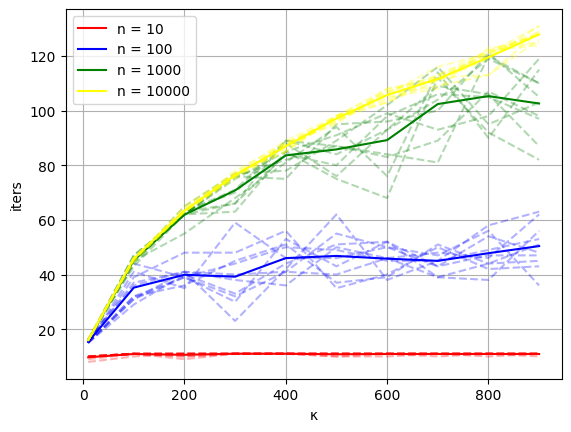

In [7]:
n = [10 ** i for i in range(1, 5)]
print(n)
color = ['red', 'blue', 'green', 'yellow']
exp1(n, color)

In [20]:
def norm_of_time(history):
    plt.figure(figsize=(12, 8))
    for l, hist in history:
        grad = np.array(hist['grad_norm'])
        grad /= grad[0]
        plt.semilogy(hist['time'], np.power(grad, 2), label=f'Размер истории = {l}')
    plt.xlabel("Секунды", fontsize=15)
    plt.ylabel(r'∥∇f(x_k)∥^2 / ∥∇f(x_0)∥^2', fontsize=15)
    plt.title('Зависимость относительного квадрата нормы градиента')
    plt.legend()
    plt.show()

def norm_of_iters(history):
    plt.figure(figsize=(12, 8))
    for l, hist in history:
        grad = np.array(hist['grad_norm'])
        grad /= grad[0]
        plt.semilogy(np.arange(len(grad)), np.power(grad, 2), label=f'Размер истории = {l}')
    plt.xlabel("Итерации", fontsize=15)
    plt.ylabel(r'∥∇f(x_k)∥^2 / ∥∇f(x_0)∥^2', fontsize=15)
    plt.title('Зависимость относительного квадрата нормы градиента')
    plt.legend()
    plt.show()

In [18]:
from sklearn.datasets import load_svmlight_file
def exp2_load():
    A, b = load_svmlight_file('C://Users//Алим//Desktop//jupyter//ML//opt//lab2//gisette_scale')
    m, n = A.shape
    oracle = create_log_reg_oracle(A, b, 1 / m)
    lis = [0, 1, 5, 10, 50, 100]
    res = []
    for l in lis:
        _, _, history_lbfgs = lbfgs(oracle, np.zeros(n), memory_size=l, trace=True)
        print(history_lbfgs)
        res.append((l, history_lbfgs))
    return res

defaultdict(<class 'list'>, {'func': [0.6931471805599467, 0.6185686393976214, 0.33865083365778365, 0.33496569010567095, 0.3313829069497663, 0.3273775398131371, 0.32355486576082454, 0.31839378670559587, 0.31324112083099626, 0.30682692716294496, 0.3004875979686557, 0.2904291292546391, 0.28840621942113515, 0.25838830944930363, 0.2515237158895648, 0.24980970903635719, 0.24797971428614296, 0.24648603792268975, 0.2449733840435443, 0.24365693705811997, 0.24232756342306172, 0.2412449741665273, 0.24015588643604527, 0.2391829315859139, 0.2382080865723739, 0.23730086657119728, 0.23639510018570958, 0.23553223397424378, 0.2346779050524024, 0.23384981188060125, 0.2330307157330658, 0.2322276255290269, 0.23143392339763844, 0.23064948113968597, 0.2298747225951982, 0.22910455298362817, 0.22834425741467718, 0.2275852049007925, 0.2268361074122405, 0.22608579959834055, 0.22534541595180266, 0.22460199599141842, 0.22386988462029234, 0.2231172968714274, 0.22237551609472372, 0.22160744890461787, 0.220848874600

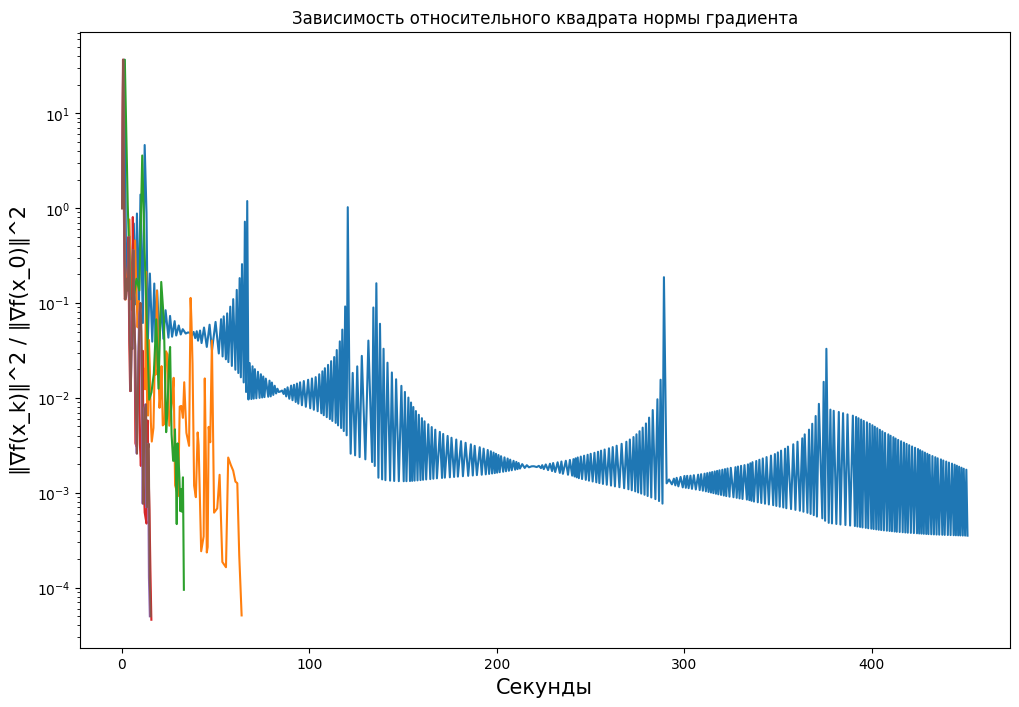

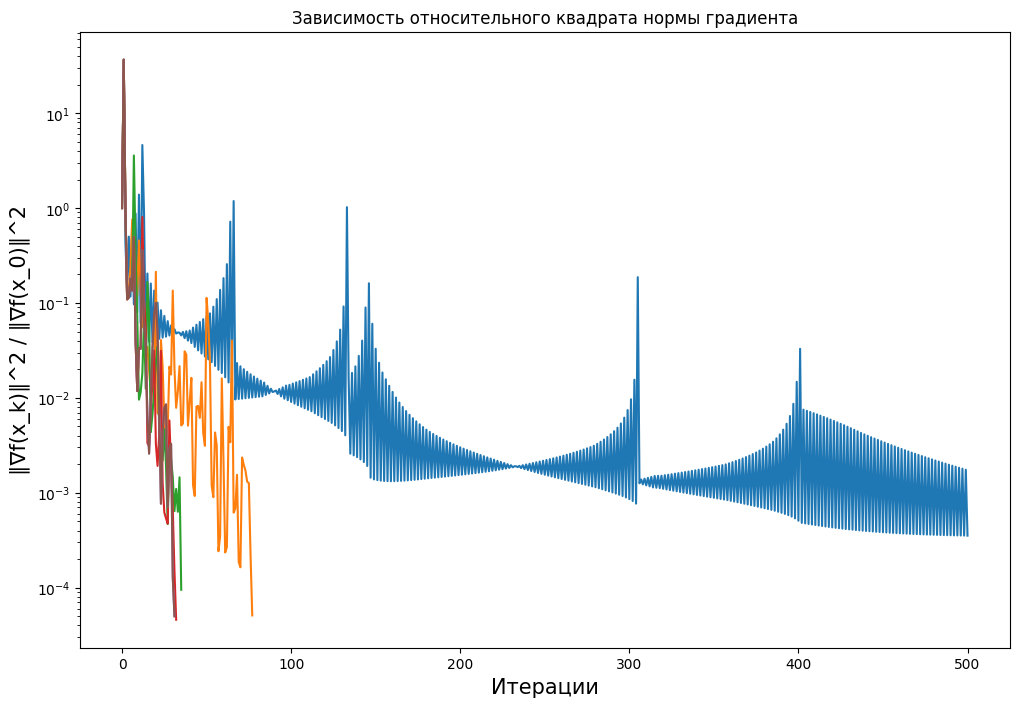

In [19]:
exp2 = exp2_load()
norm_of_time(exp2)
norm_of_iters(exp2)

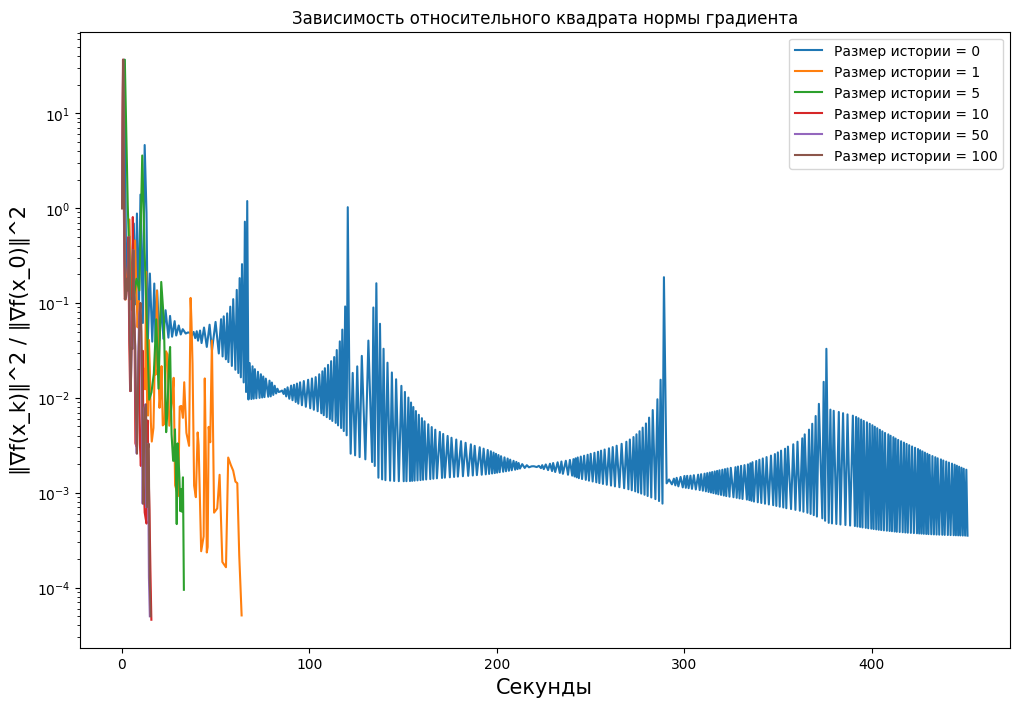

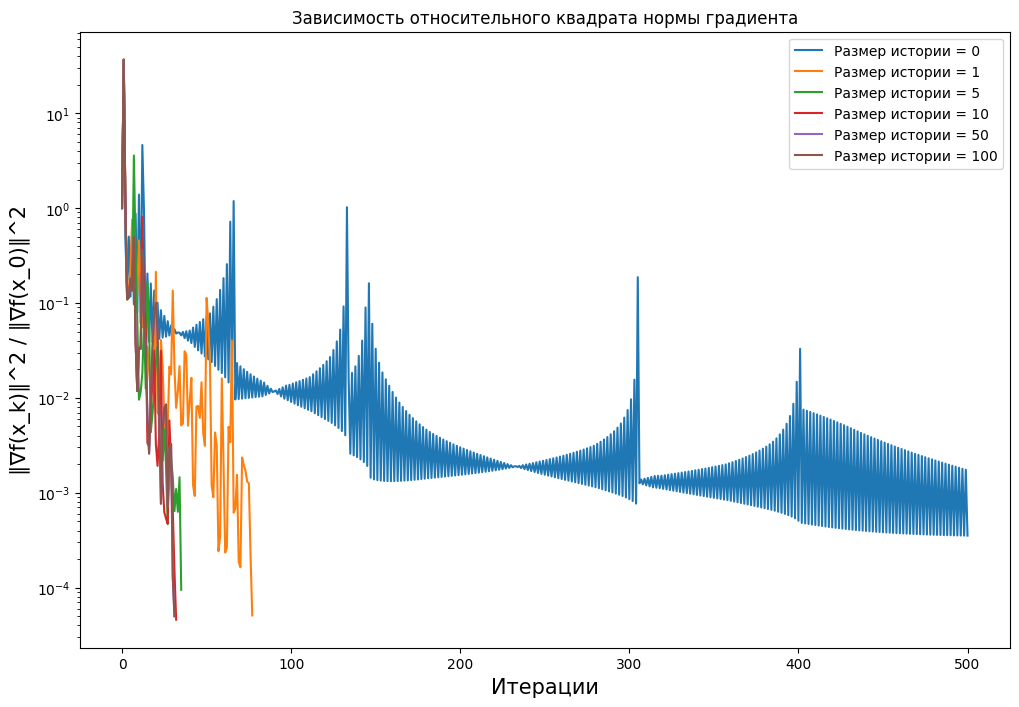

In [21]:
norm_of_time(exp2)
norm_of_iters(exp2)

In [16]:
def func_of_iter(all_hist, dataset):
    plt.figure(figsize=(12, 8))
    mtd = ['HFN', 'LBFGS', 'GD']
    colors = ['r', 'g', 'b']
    for i, hist in enumerate(all_hist):
        plt.plot(np.arange(len(hist['func'])), np.array(hist['func']), label=f'{mtd[i]}', color=colors[i])
    plt.xlabel('Итерации', fontsize=15)
    plt.ylabel('func', fontsize=15)
    plt.title(f'{dataset}')
    plt.grid()
    plt.legend()
    plt.show()

def func_of_time(all_hist, dataset):
    plt.figure(figsize=(12, 8))
    mtd = ['HFN', 'LBFGS', 'GD']
    colors = ['r', 'g', 'b']
    for i, hist in enumerate(all_hist):
        plt.plot(hist['time'], np.array(hist['func']), label=f'{mtd[i]}', color=colors[i])
    plt.xlabel('Время', fontsize=15)
    plt.ylabel('func', fontsize=15)
    plt.title(f'{dataset}')
    plt.grid()
    plt.legend()
    plt.show()

def norm_of_time(all_hist, dataset):
    plt.figure(figsize=(12, 8))
    mtd = ['HFN', 'LBFGS', 'GD']
    colors = ['r', 'g', 'b']
    for i, hist in enumerate(all_hist):
        grad = np.array(hist['grad_norm'])
        grad /= grad[0]
        plt.semilogy(hist['time'], np.power(grad, 2), label=f'{mtd[i]}', color=colors[i])
    plt.xlabel('Время', fontsize=15)
    plt.ylabel(r'∥∇f(x_k)∥^2 / ∥∇f(x_0)∥^2', fontsize=15)
    plt.title(f'{dataset}')
    plt.grid()
    plt.legend()
    plt.show()

In [53]:
def exp3_load():
    datasets = [
        'w8a',
        'gisette_scale',
        'real-sim',
        'news20.binary',
        'rcv1.binary'
    ]

    methods = [hessian_free_newton, lbfgs, gradient_descent]

    for ds in datasets:
        print(f'Текущий датасет: {ds}')
        print(f'C://Users//Алим//Desktop//jupyter//ML//opt//lab2//{ds}')
        A, b = load_svmlight_file(f'C://Users//Алим//Desktop//jupyter//ML//opt//lab2//{ds}')
        m, n = A.shape
        oracle = create_log_reg_oracle(A, b, 1 / m)
        res = []
        for i, algorithm in enumerate(methods):
            _, _, history = algorithm(oracle, np.zeros(n), trace=True)
            print(f'{i} method')
            res.append(history)
            print(res[0]['func'])
        func_of_iter(res, ds)
        func_of_time(res, ds)
        norm_of_time(res, ds)

Текущий датасет: w8a
C://Users//Алим//Desktop//jupyter//ML//opt//lab2//w8a
0 method
[0.6931471805599465, 0.466651717050861, 0.356390568852177, 0.2539357169435134, 0.19056662028943958, 0.15180399598643232, 0.13522609893104817]
1 method
[0.6931471805599465, 0.466651717050861, 0.356390568852177, 0.2539357169435134, 0.19056662028943958, 0.15180399598643232, 0.13522609893104817]
2 method
[0.6931471805599465, 0.466651717050861, 0.356390568852177, 0.2539357169435134, 0.19056662028943958, 0.15180399598643232, 0.13522609893104817]


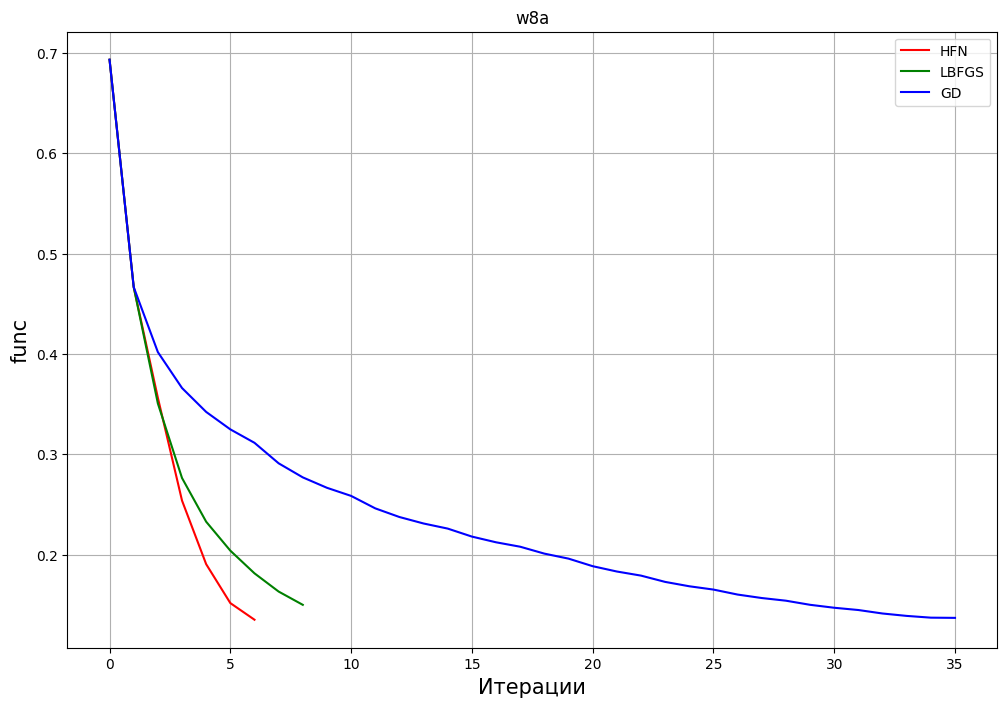

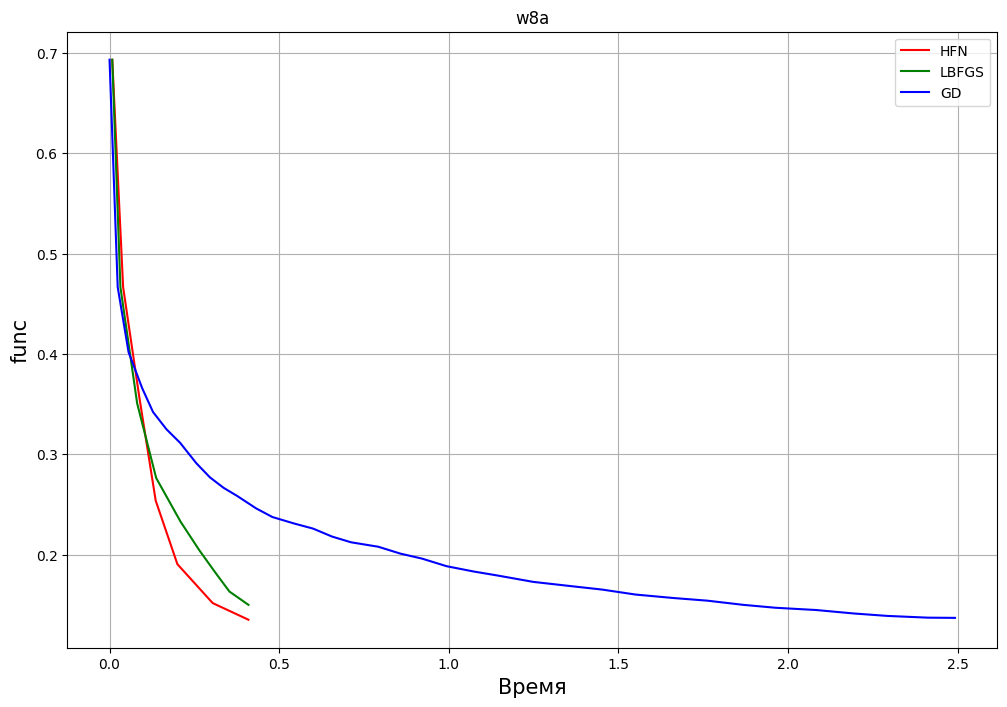

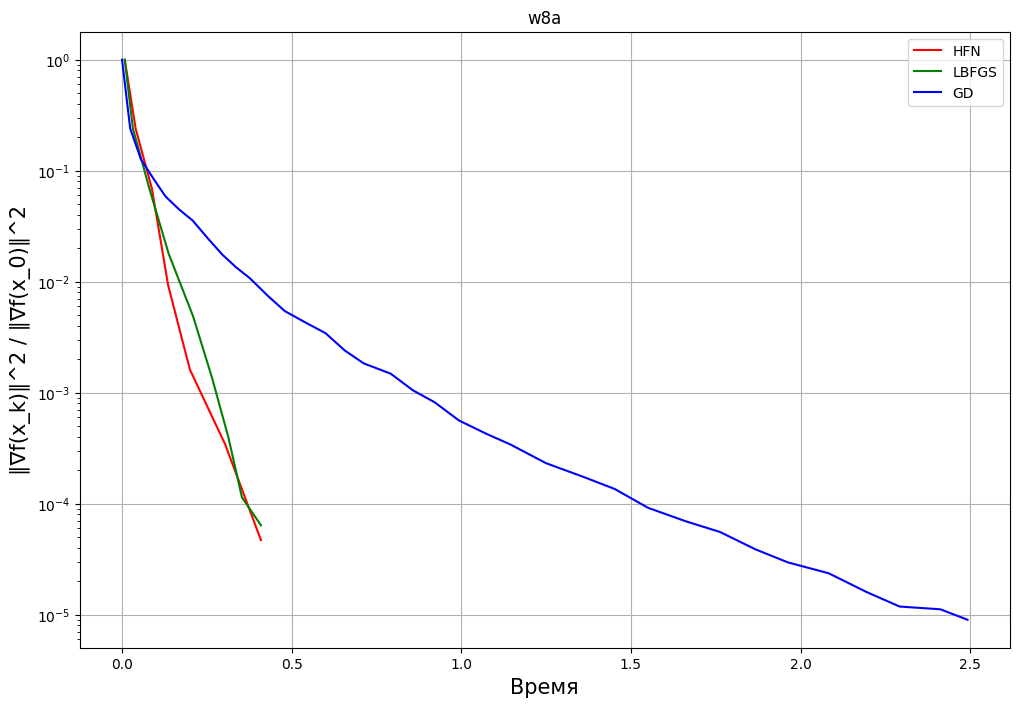

Текущий датасет: gisette_scale
C://Users//Алим//Desktop//jupyter//ML//opt//lab2//gisette_scale
0 method
[0.6931471805599467, 0.26064720855242357, 0.13128618005063677, 0.09924710184711831, 0.04128457713225361, 0.0158778579207197, 0.007376604515228149]
1 method
[0.6931471805599467, 0.26064720855242357, 0.13128618005063677, 0.09924710184711831, 0.04128457713225361, 0.0158778579207197, 0.007376604515228149]
2 method
[0.6931471805599467, 0.26064720855242357, 0.13128618005063677, 0.09924710184711831, 0.04128457713225361, 0.0158778579207197, 0.007376604515228149]


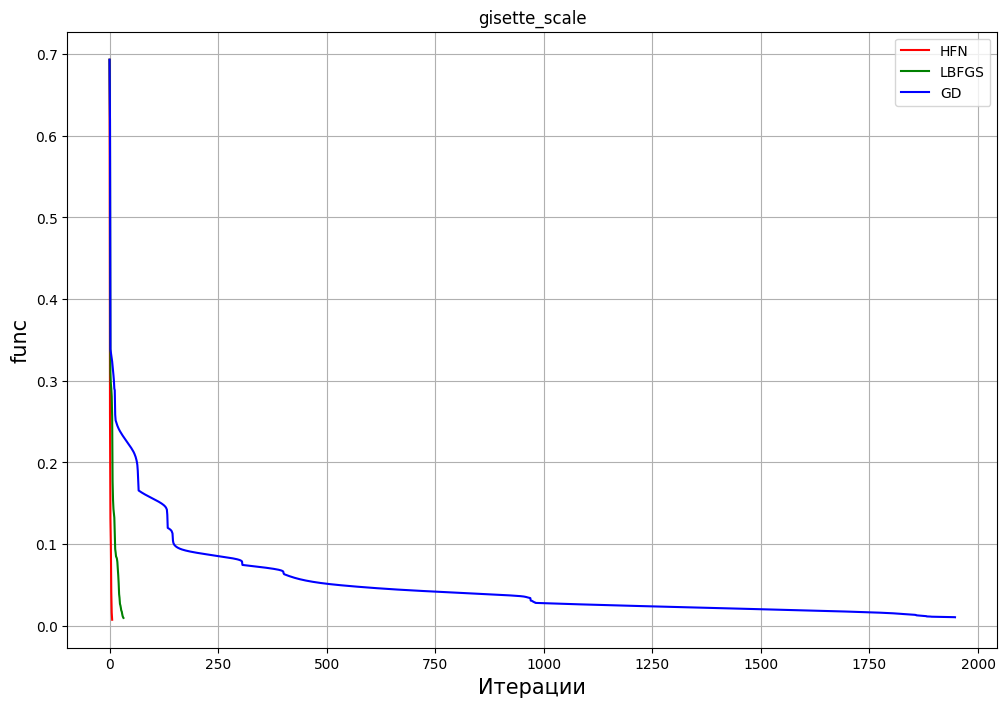

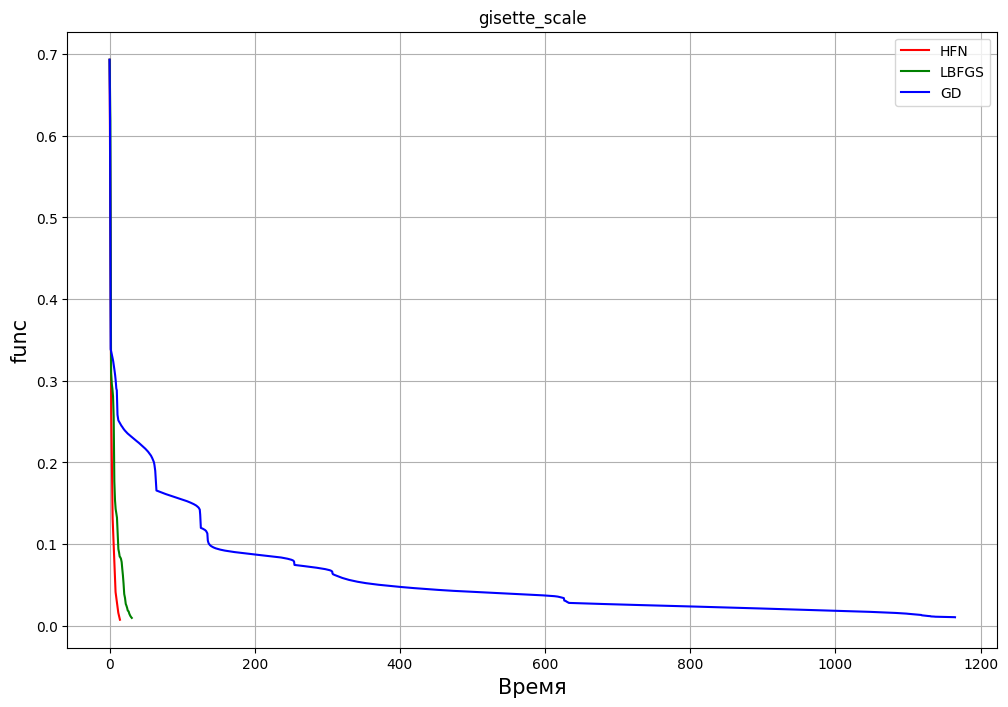

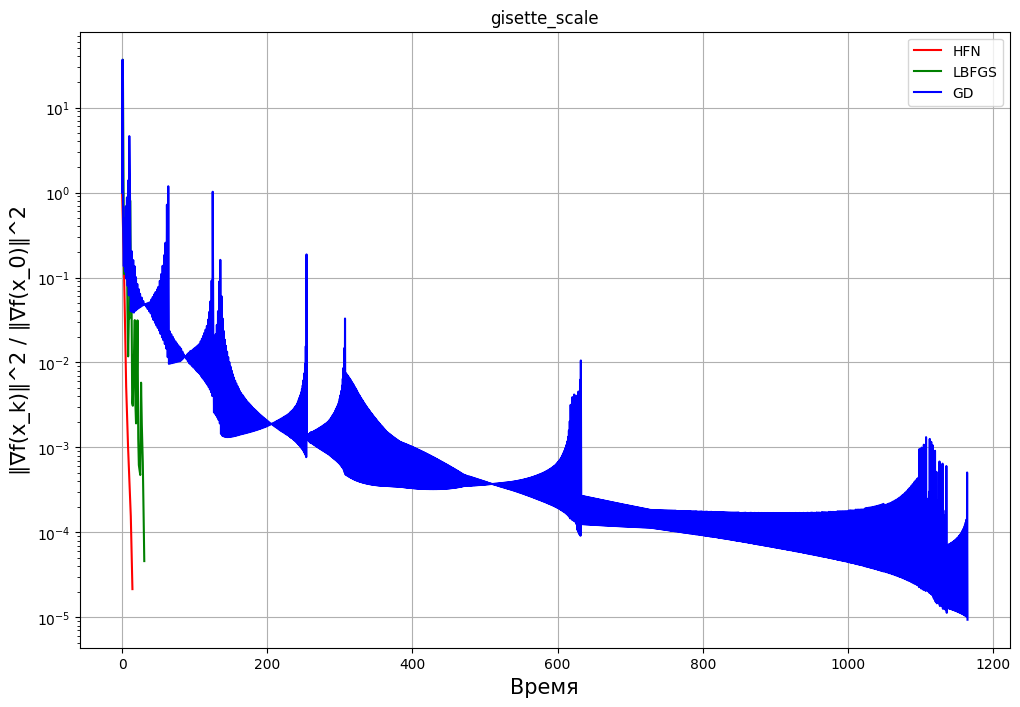

Текущий датасет: real-sim
C://Users//Алим//Desktop//jupyter//ML//opt//lab2//real-sim
0 method
[0.6931471805599471, 0.3164944736311884, 0.1790015799197585, 0.1498820960373381, 0.14547256968838052]
1 method
[0.6931471805599471, 0.3164944736311884, 0.1790015799197585, 0.1498820960373381, 0.14547256968838052]


c:\Users\Алим\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


2 method
[0.6931471805599471, 0.3164944736311884, 0.1790015799197585, 0.1498820960373381, 0.14547256968838052]


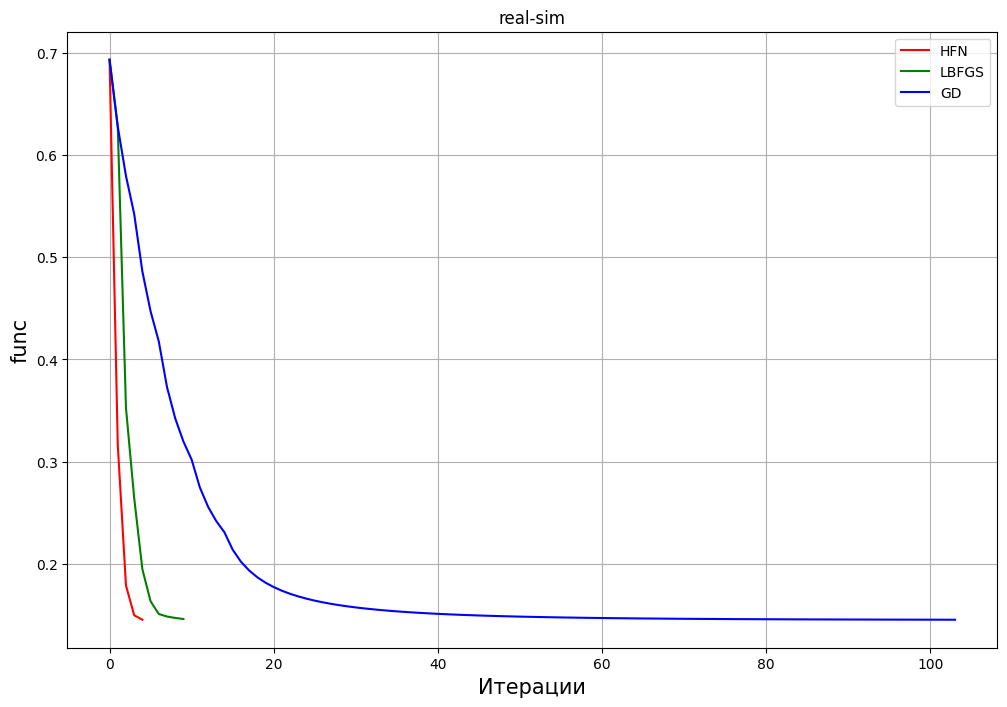

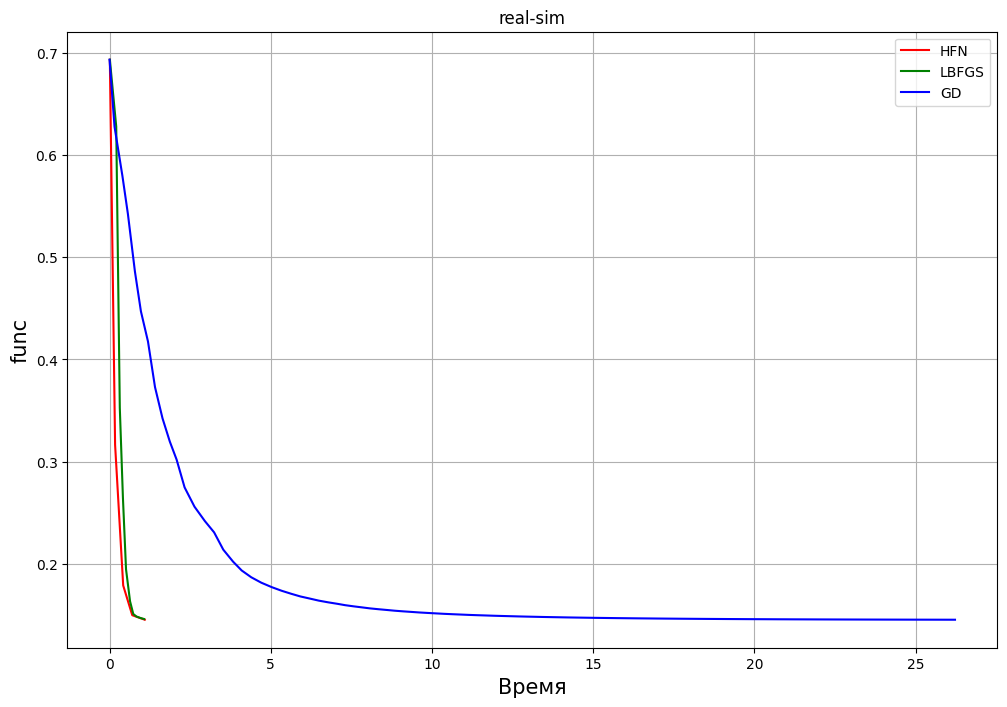

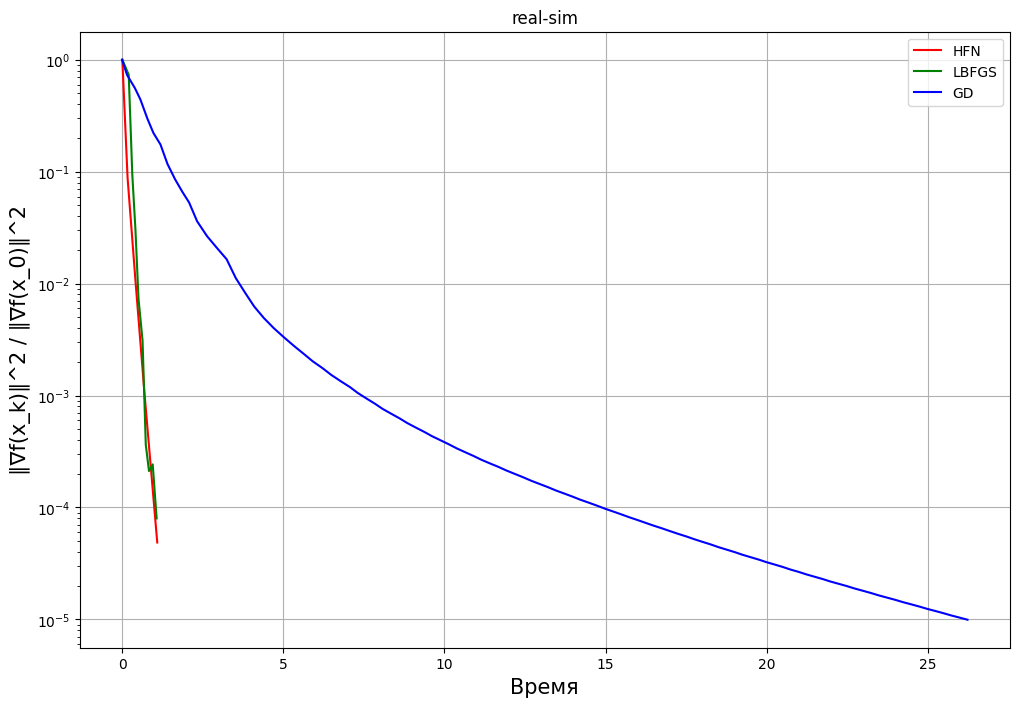

Текущий датасет: news20.binary
C://Users//Алим//Desktop//jupyter//ML//opt//lab2//news20.binary


ValueError: could not convert string to float: b'BZh91AY&SY+\xb5\x15\xac\x00z\x14X\x00`\x10@\x03\x7f\xf0c\xe6\x9fy\xe9\x91E\x1b`\x15\x14'

In [54]:
exp3_load()

In [14]:
from sklearn.datasets import load_svmlight_file
def exp3_continue():
    datasets = [
        'rcv1tes.binary',
        'news20.scale'
    ]

    methods = [hessian_free_newton, lbfgs, gradient_descent]

    for ds in datasets:
        print(f'Текущий датасет: {ds}')
        print(f'C://Users//Алим//Desktop//jupyter//ML//opt//lab2//{ds}')
        A, b = load_svmlight_file(f'C://Users//Алим//Desktop//jupyter//ML//opt//lab2//{ds}')
        m, n = A.shape
        oracle = create_log_reg_oracle(A, b, 1 / m)
        res = []
        for i, algorithm in enumerate(methods):
            _, _, history = algorithm(oracle, np.zeros(n), trace=True)
            print(f'{i} method')
            res.append(history)
            print(res[0]['func'])
        func_of_iter(res, ds)
        func_of_time(res, ds)
        norm_of_time(res, ds)

Текущий датасет: rcv1tes.binary
C://Users//Алим//Desktop//jupyter//ML//opt//lab2//rcv1tes.binary
0 method
[0.6931471805599059, 0.2720985237666358, 0.14258196066395998, 0.09895449580098367, 0.08709412801910543, 0.08495744952552223]
1 method
[0.6931471805599059, 0.2720985237666358, 0.14258196066395998, 0.09895449580098367, 0.08709412801910543, 0.08495744952552223]
2 method
[0.6931471805599059, 0.2720985237666358, 0.14258196066395998, 0.09895449580098367, 0.08709412801910543, 0.08495744952552223]


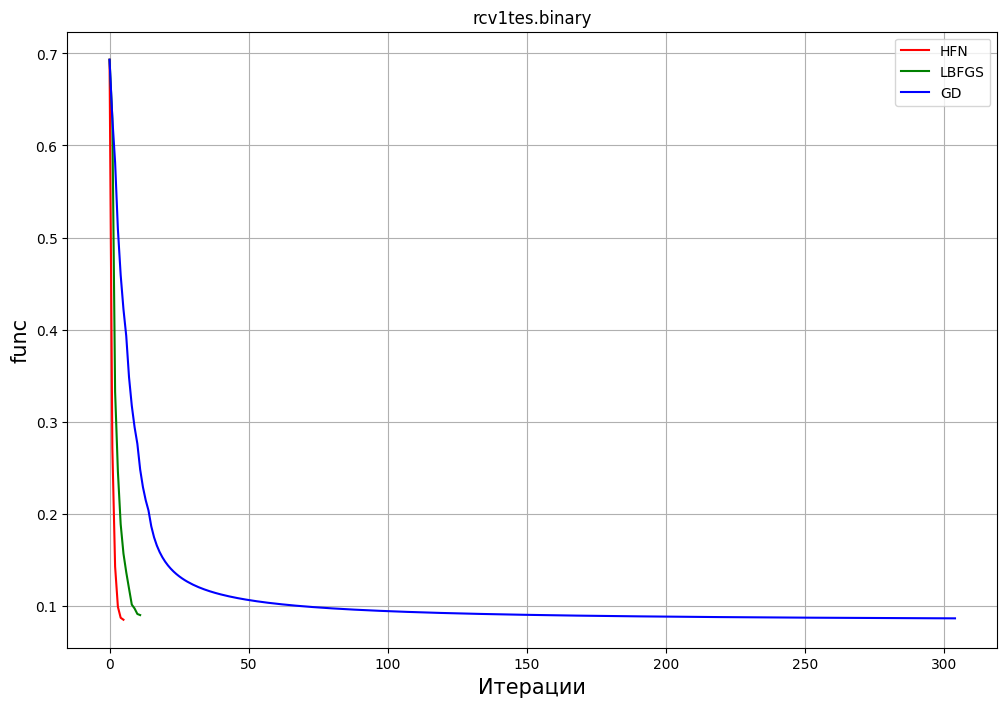

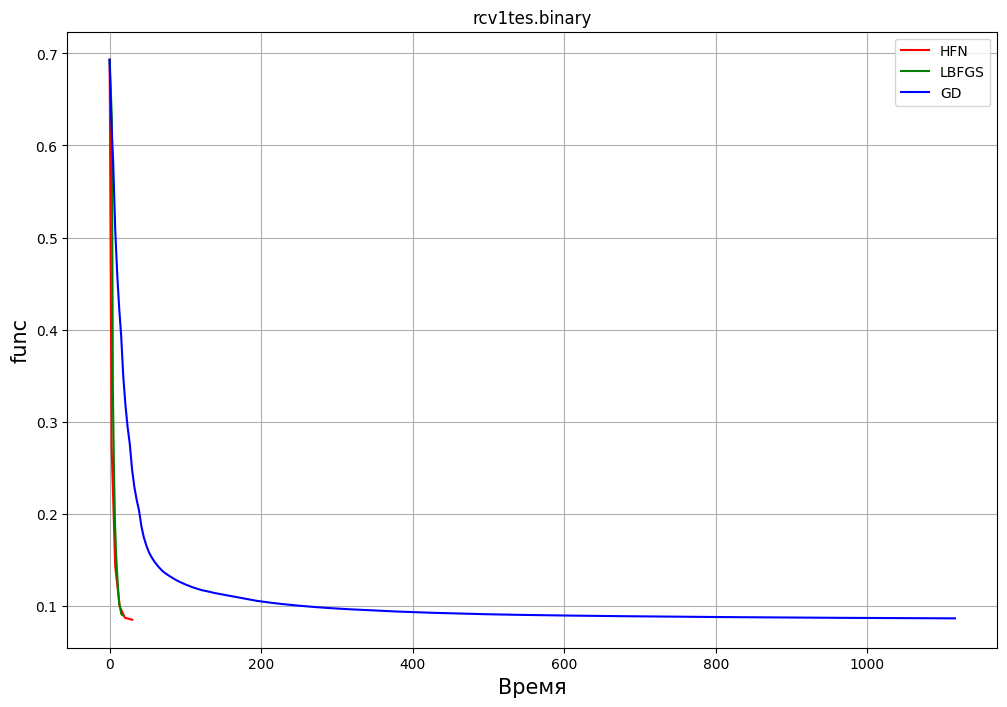

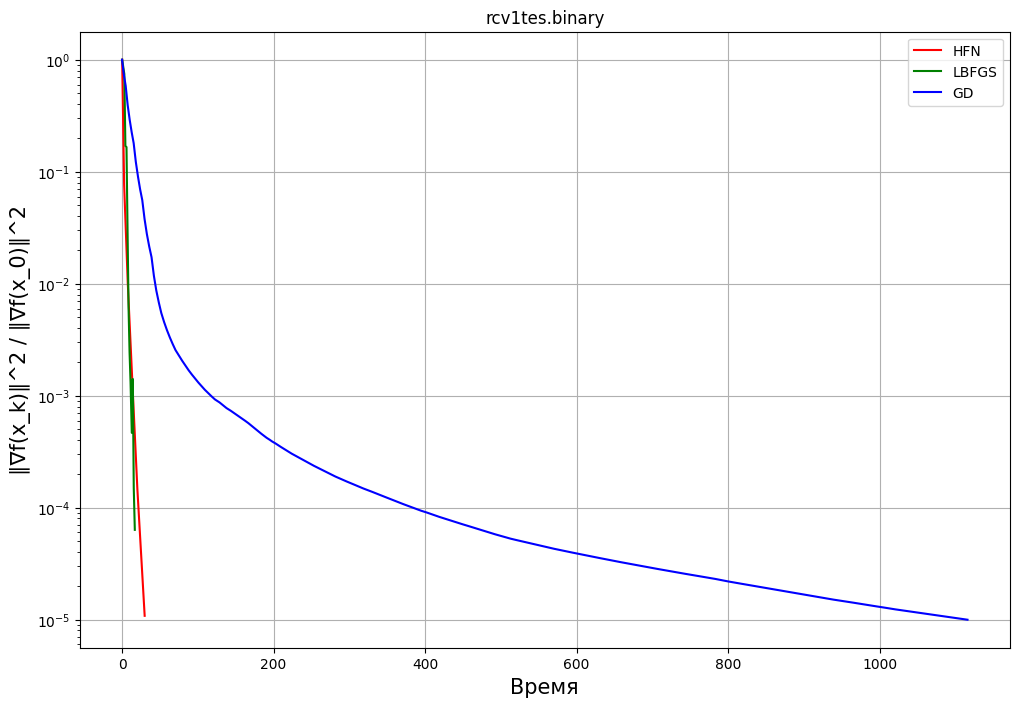

Текущий датасет: news20.scale
C://Users//Алим//Desktop//jupyter//ML//opt//lab2//news20.scale
0 method
[0.6931471805599447, 0.26691296735873526, 0.16234036323907805, 0.08953276321090282, 0.046571221216686005, 0.026351708865795853]
1 method
[0.6931471805599447, 0.26691296735873526, 0.16234036323907805, 0.08953276321090282, 0.046571221216686005, 0.026351708865795853]
2 method
[0.6931471805599447, 0.26691296735873526, 0.16234036323907805, 0.08953276321090282, 0.046571221216686005, 0.026351708865795853]


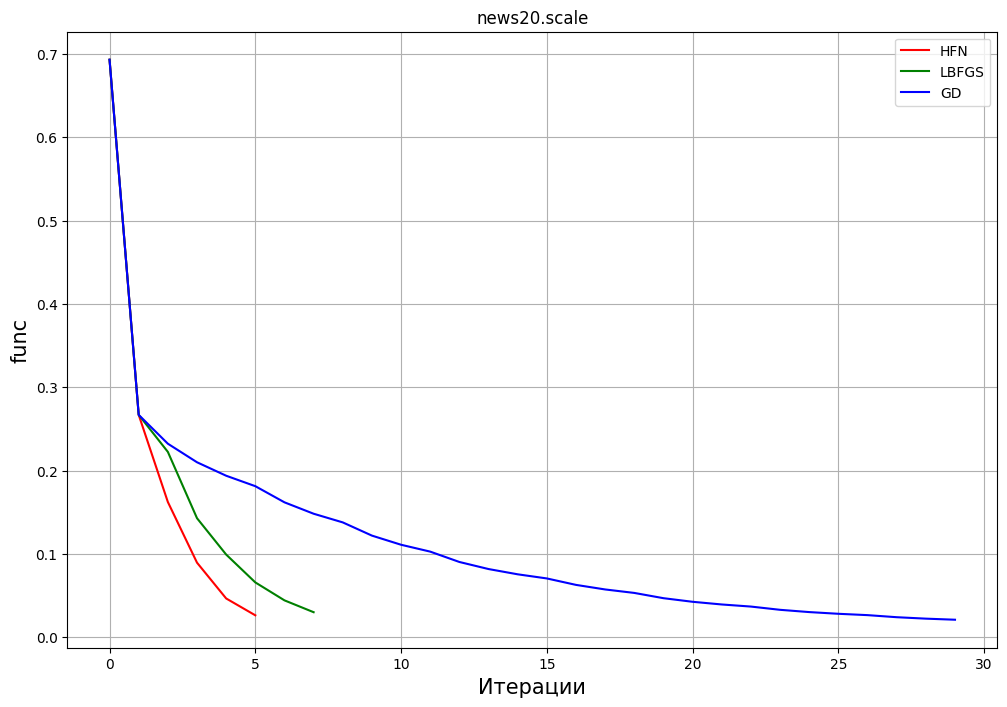

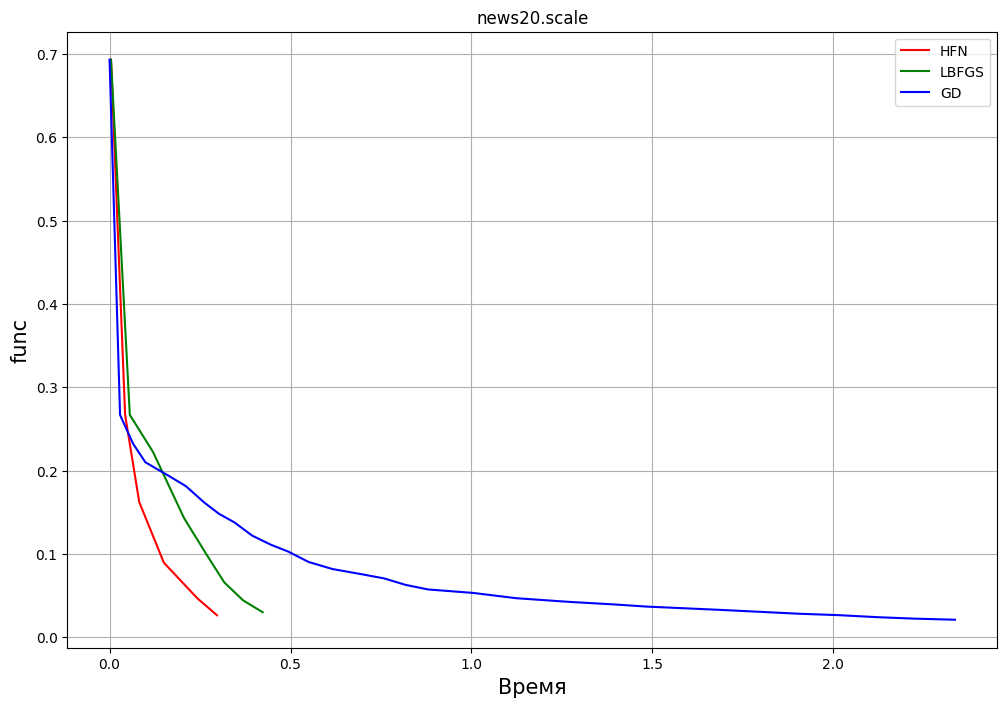

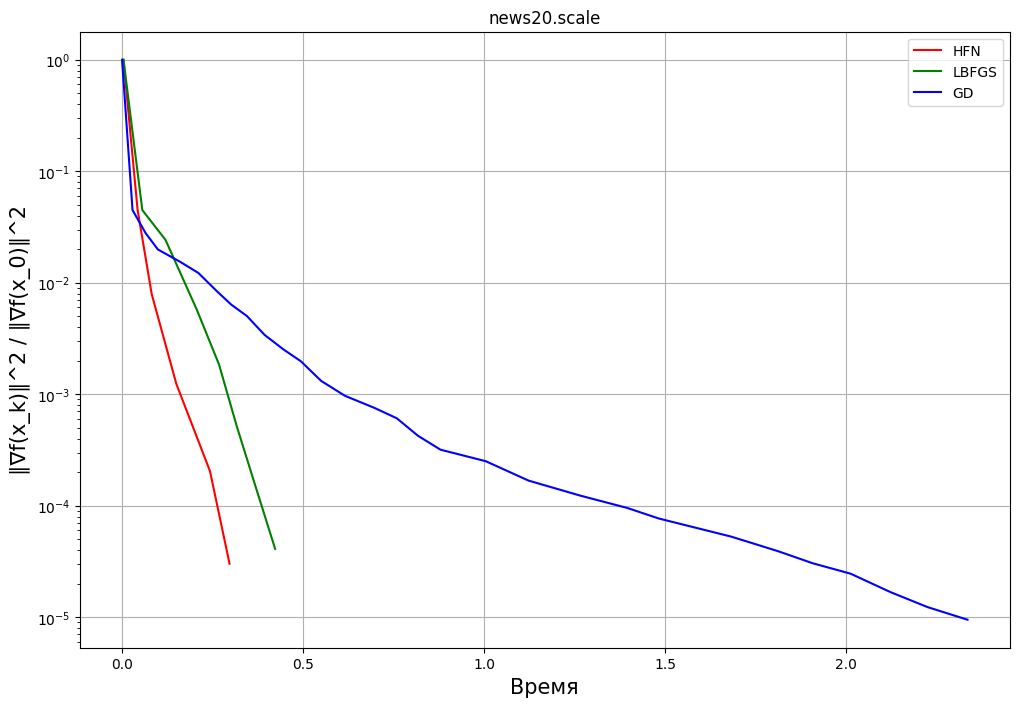

In [17]:
exp3_continue()